<a href="https://colab.research.google.com/github/salocinnobot/Fashion-MNIST/blob/main/Fashion-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization of notebook to work with Kaggle Dataset

In [4]:
!pip install kaggle

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d zalando-research/fashionmnist

 90% 62.0M/68.8M [00:00<00:00, 84.9MB/s]
100% 68.8M/68.8M [00:00<00:00, 91.0MB/s]


In [10]:
! unzip fashionmnist

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [11]:
## We see here, that Google Colab provide a LINUX directory from which we can access our data
!ls

fashion-mnist_test.csv	 kaggle.json		 t10k-labels-idx1-ubyte
fashion-mnist_train.csv  sample_data		 train-images-idx3-ubyte
fashionmnist.zip	 t10k-images-idx3-ubyte  train-labels-idx1-ubyte


# Let's separate our training data and our test data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from skimage.measure import block_reduce
from scipy.signal import convolve2d

In [13]:
training_data = pd.read_csv("fashion-mnist_train.csv")
test_data = pd.read_csv("fashion-mnist_test.csv")

In [14]:
test_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
print(training_data.shape)
print(test_data.shape)

(60000, 785)
(10000, 785)


In [16]:
y = training_data['label']
X = training_data.drop('label', axis = 1)

In [17]:
(X_train, y_train) = X, y

In [18]:
X_train = X_train.to_numpy()/255.
X_train = X_train.reshape(-1, 28, 28)
y_train = y_train.to_numpy()

In [19]:
y = test_data['label']
X = test_data.drop('label', axis = 1)

In [20]:
(X_test, y_test) = X, y

In [21]:
X_test = X_test.to_numpy()/255.
X_test = X_test.reshape(-1, 28, 28)
y_test = y_test.to_numpy()

Let's visualize some of the images that we will be using for our Neural Network, to gain an intuition into the methods we could use.

In [22]:
def plot_images_in_a_row(ims, color):    
  'Takes a list/array of images and plots them spaced horizontally.'
  _, axs = plt.subplots(1, len(ims), figsize = (20,5))
  for im, ax in zip(ims, axs.ravel()):
    ax.imshow(im, cmap = color)
    ax.axis('off')

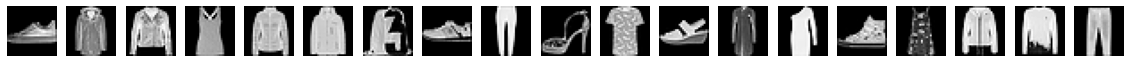

In [24]:
plot_images_in_a_row(X_train[21:40], "gray")

#### The images are of relatively small size (28, 28), thus the use of a convlutional neural net won't necessarily be maximizing the advantages of using kernels which is charactersitic of the CNN   

#### Let's encode our y_train and y_test as a categorical vector of 0, 1 to facilitate the use of categorical variables training our CNN.

In [25]:
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [26]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [27]:
print(y_train[0], y_train_cat[0], np.argmax(y_train_cat[0]))

2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2


#### Let's go over some of the most important convolutions, to understand as to how best approach our CNN

Let's review quickly some intuitive interpretations of the relevant definitions for our CNN
- Kernel: A nxm matrix that is slid over our image. The operation of the kernel with the image is a multiplication, in which each value in our new image is a sum of the element-wise multiplication of every pixel in our kernel with the underlying pixel that it is being applied to.
- Filter: A filter is a concatentation of kernels of the form nxmxd, where d is the kernel specified to channel (in the case of RGB, there d would 3)
  - In the case of applying a filter across 3 channels, the RGB values would be summed to produce one final output image
  - In the case of our image data, we don't have to worry about the use of filters as we're only dealing with channel (grayscale) 

Let's list our convolutions:
- Ridge4
- Ridge8
- Sharpening 
- Edge Detection

In [40]:
X_train[0].shape

(28, 28)

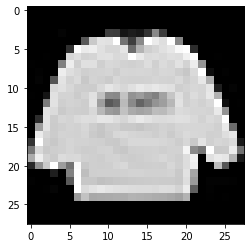

In [41]:
im = X_train[0]
plt.imshow(im, cmap = 'gray')

Something I learned 
- np.array(...) allows you return the entire subset of the specified indices


In [66]:
def convolve_single_channel(im, m):
  im_conv = im.copy()  
  im_conv[...] = convolve2d(im_conv[...], m, mode = 'same')
  return im_conv

## Since our images are of grayscale, we don't need to use convolve_and_merge as 
## only applies to mulit-channel images
def convolve_and_merge(im, m):
  return convolve_single_channel(im, m).sum(axis = -1)

In [67]:
## These were our original convolutions, used to find edges yet they don't work as well 
## as we'd like them to
m_ridge4 = np.array([[0.,-1,0],
                    [-1,4,-1],
                    [0,-1,0]]) 

m_ridge8 = np.array([[-1.,-1,-1],
                    [-1,8,-1],
                    [-1,-1,-1]]) 

m_sharpen = np.array([[0.,-1,0],
                    [-1,5,-1],
                    [0,-1,0]]) 

## Let's add some other convolutions to see how we can better extract the features necessary for our CNN
m_edge_1 = np.array([[-1, -2, -1],
                     [0,0,0],
                     [1,2,1]])

m_edge_2 = np.array([[ -1, 0, 1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])


## Here we change our blur size so we don't overpower the blur relative to our picture size
blur_size = 3
m_blur = np.ones((blur_size,blur_size))/blur_size**2

## Let's add a deconvolution (tranposed convolution) to see how the image will look with greater dimensions


385.1058823529412


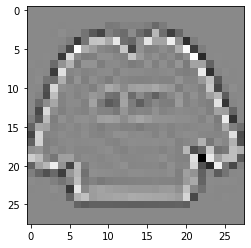

571.443137254902


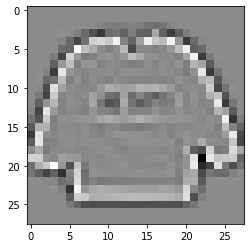

188.80784313725496


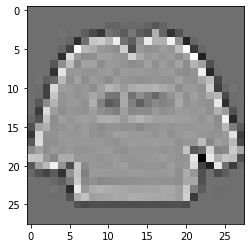

51.88583877995643


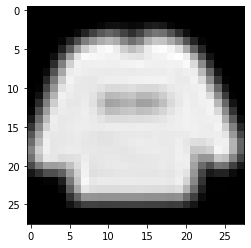

654.7372549019608


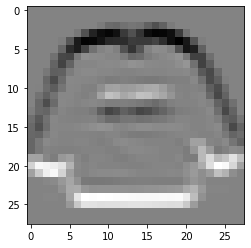

1111.372549019608


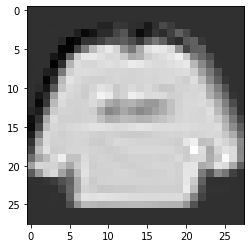

In [68]:
## Here we perform some convolutions for images that in our grayscale
images = np.array([])

for m in [m_ridge4, m_ridge8, m_sharpen, m_blur, m_edge_1, m_edge_2]:
  ims = convolve_single_channel(im, m)
  print(np.sum(np.abs(ims - im)))
  plt.imshow(ims, cmap = 'gray')
  plt.show()

In [69]:
## Let's perform an upsampling convolution using a sequential model (only way to upsample)
im_up = im.copy()
print(im_up.shape)
im_up = im_up.reshape(1, 28, 28, 1)
print(im_up.shape)

(28, 28)
(1, 28, 28, 1)


In [71]:
model = keras.models.Sequential()
model.add(keras.layers.UpSampling2D(input_shape = (28, 28, 1)))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_12 (UpSamplin  (None, 56, 56, 1)        0         
 g2D)                                                            
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [72]:
y_hat_conv = model.predict(im_up)

In [73]:
y_hat_conv = y_hat_conv.reshape(56, 56)

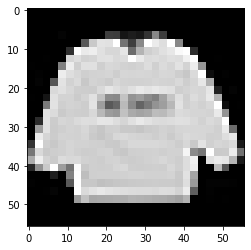

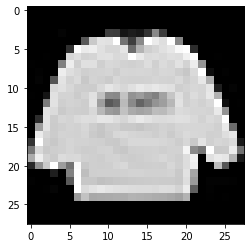

In [74]:
plt.imshow(y_hat_conv, cmap = 'gray')
plt.show()
plt.imshow(im, cmap = 'gray')
plt.show()

Notes for running convolutional layers
- Add padding to the original image to allow for the kernel to slide over the boundaries of our image.
- On pooling methods:
  - Max pooling: Take the maximum of the pixels in that channel. 
    - Useful for when we have images that need brightening, as it takes the brightest pixel in that kernel (highest pixel value) and assigns that value to the value in the output image
  - Min pooling: Takes the minimum of the pixels in that channel.
    - Useful for when we have images that need darkening, as it takes the darkest image in that kernel (lowest pixel value) and assigns that value to the value in the output image
  - Average pooling: Takes the average of the pixels in that kernel in that channel
    - Useful for smoothing the edges of a image, Takes the average of the pixels in that kernel (average of the pixel values) and assigns that value to the value in the output image